## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%.

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)).

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

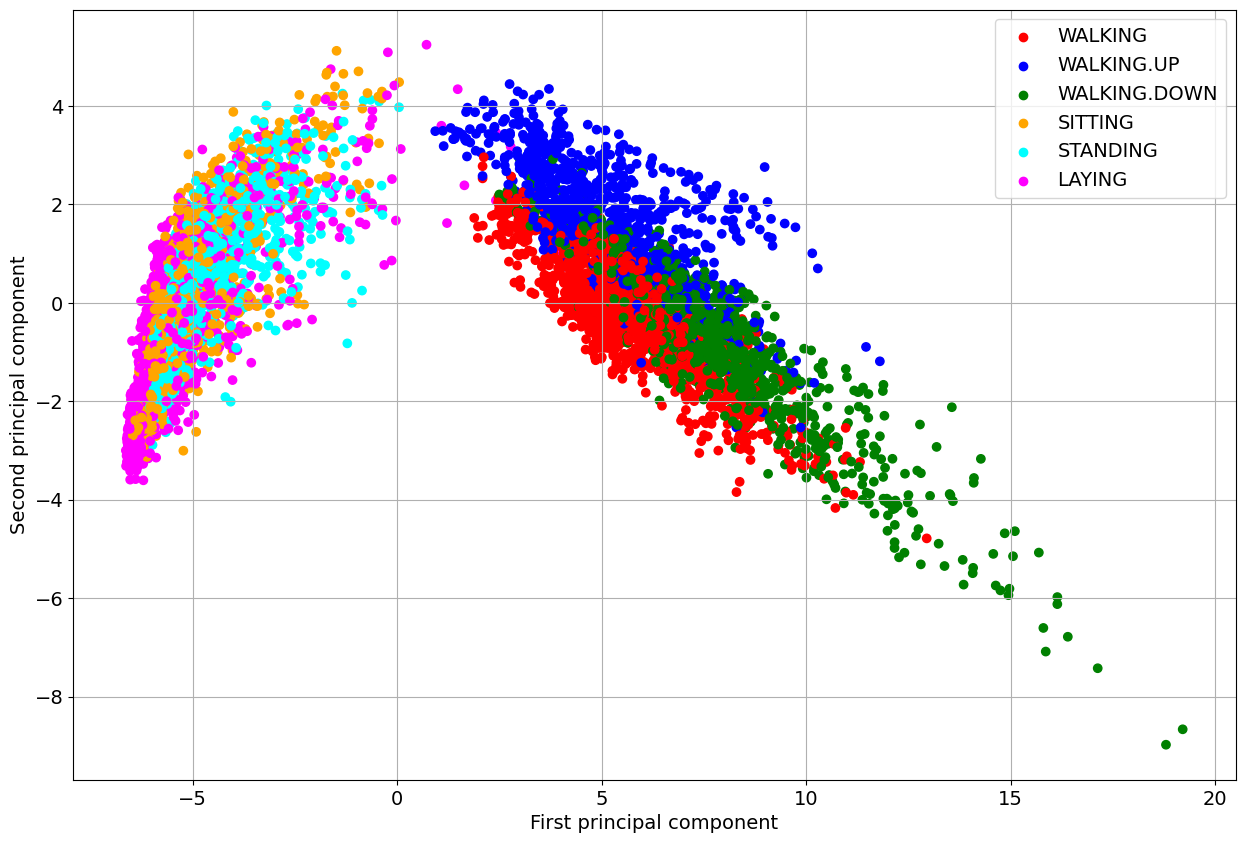

In [ ]:
X_train_with_engineered_features = np.genfromtxt("X_train.txt")
y_train = np.genfromtxt("y_train.txt")

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0],
                x[1],
                c=colors_list[idx],
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [ ]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()

    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [ ]:
# Input Data

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [ ]:
from sklearn.model_selection import train_test_split

# Процент данных для валидации
validation_split = 0.2

# Разделение X_train и y_train на тренировочный и валидационный набор
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=validation_split, random_state=42
)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Гиперпараметры
n_hidden = 32          # Количество нейронов в скрытых слоях (для начальной конфигурации)
n_classes = 6          # Количество классов для классификации
learning_rate = 0.001  # Скорость обучения (уменьшенная для точной настройки)
batch_size = 128       # Размер мини-батча для ускорения обучения
epochs = 50            # Максимальное количество эпох

# Построение модели
# Используем Sequential API для создания последовательной архитектуры
model = Sequential([
    # Первый LSTM слой
    LSTM(64, input_shape=(n_steps, n_input), return_sequences=True),  # return_sequences=True возвращает последовательность для следующего слоя
    Dropout(0.4),  # Dropout для предотвращения переобучения, вероятность 40%

    # Второй LSTM слой
    LSTM(64, return_sequences=True),  # Еще один слой с 64 нейронами
    Dropout(0.4),  # Dropout 40%

    # Третий LSTM слой
    LSTM(32),  # Этот слой возвращает вектор для полносвязного слоя
    Dropout(0.3),  # Dropout 30%

    # Полносвязный слой (Dense) с softmax-активацией
    Dense(n_classes, activation='softmax')  # Выходной слой с 6 нейронами (по одному на класс)
])

# Компиляция модели
# Оптимизатор: Adam (адаптивный алгоритм с быстрым сходом)
# Функция потерь: sparse_categorical_crossentropy, так как целевые метки (y_train, y_val) представлены в виде целых чисел
# Метрики: точность (accuracy)
model.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучение модели
# history сохранит данные о процессе обучения (например, значения потерь и точности на каждой эпохе)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),  # Валидационный набор для оценки модели на каждой эпохе
                    batch_size=batch_size,          # Размер мини-батча
                    epochs=epochs,                  # Максимальное количество эпох
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
                        # EarlyStopping остановит обучение, если валидационная ошибка не будет уменьшаться в течение 5 эпох
                    ])

# Оценка модели на тестовом наборе данных
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Вывод финальной точности
print(f"Test Accuracy: {test_accuracy:.2f}")  # Округленная точность на тестовом наборе

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 609ms/step - accuracy: 0.3918 - loss: 1.4768 - val_accuracy: 0.5323 - val_loss: 1.0455
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 39s 576ms/step - accuracy: 0.5591 - loss: 1.0372 - val_accuracy: 0.6689 - val_loss: 0.7727
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 494ms/step - accuracy: 0.6655 - loss: 0.7878 - val_accuracy: 0.7315 - val_loss: 0.6053
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 547ms/step - accuracy: 0.7430 - loss: 0.6214 - val_accuracy: 0.7811 - val_loss: 0.5318
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 555ms/step - accuracy: 0.8005 - loss: 0.5160 - val_accuracy: 0.8518 - val_loss: 0.4264
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 536ms/step - accuracy: 0.8460 - loss: 0.4359 - val_accuracy: 0.9103 - val_loss: 0.2733
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 530ms/step - accuracy: 0.9099 - loss: 0.3034 - val_accuracy: 0.9055 - val_loss: 0.2656
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 525ms/step - accuracy: 0.9194 - loss: 0.2516 - val_accu

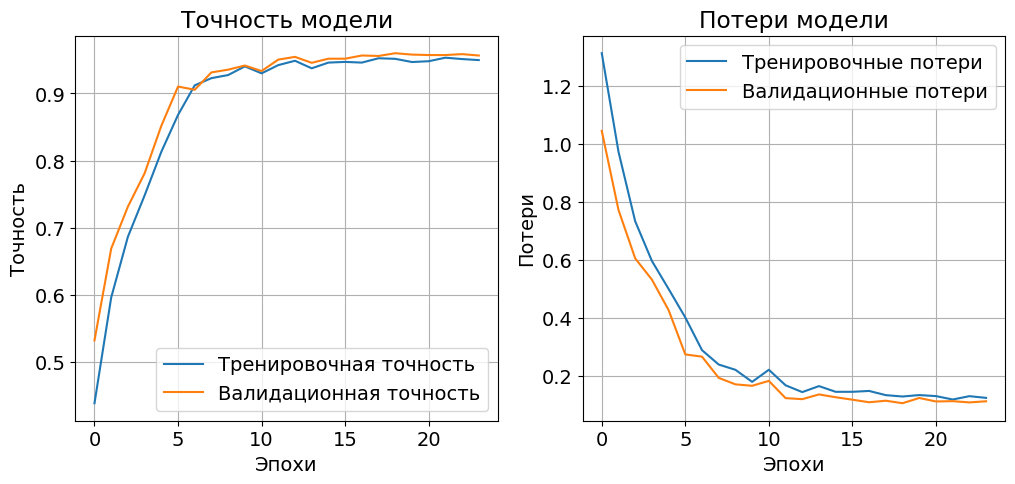

In [ ]:
import matplotlib.pyplot as plt

# Построение графиков точности и потерь
def plot_training_history(history):
    # График точности
    plt.figure(figsize=(12, 5))

    # Точность
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Тренировочная точность')
    plt.plot(history.history['val_accuracy'], label='Валидационная точность')
    plt.title('Точность модели')
    plt.xlabel('Эпохи')
    plt.ylabel('Точность')
    plt.legend()
    plt.grid(True)

    # Потери
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Тренировочные потери')
    plt.plot(history.history['val_loss'], label='Валидационные потери')
    plt.title('Потери модели')
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.legend()
    plt.grid(True)

    plt.show()

# Построение графиков
plot_training_history(history)

При первом прогоне, я получил реультат 86% test accuracy,
моя модель:



In [ ]:
model = Sequential([
    LSTM(n_hidden, input_shape=(n_steps, n_input), return_sequences=True),
    Dropout(0.5),
    LSTM(n_hidden),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])

На втором прогоне я улучшил модель, см в коде, и поставил learning_rate = 0.0005. Время обучения замедлилось, и в коне я не получилжелаемого результат test accuracy составл 89%

На тетьем прогоне, я вернул learning_rate = 0.001. И начал экспериментировать с Dropout. Экспериментальным путем, мне удалось найи оптимальный уровень Dropout в 0.4, также я увеличил batch_size c 64 до 128. В конце я получил результат 0.91

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [3]:
# Your experiments here
# подготовка данных
import zipfile
import os

# Пути к архиву и директории для извлечения
zip_path = "data.zip"
extract_path = "data"

# Извлечение данных
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Данные извлечены в папку: {extract_path}")

Данные извлечены в папку: data


In [31]:
import os
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from torch import nn, optim

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
DATA_DIR = "data/data"
BATCH_SIZE = 32

# Аугментация и загрузка данных
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_transforms)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [35]:
for inputs, paths in test_loader:
    print(paths[:5])  # Первые 5 путей файлов
    break

('46.jpeg', '1058.jpeg', '482.jpeg', '858.jpeg', '1202.jpeg')


In [36]:
from torch.utils.data import Dataset
from PIL import Image
import glob

class TestDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.filepaths = glob.glob(os.path.join(folder_path, "*.jpeg"))  # или другой формат: *.png
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        image = Image.open(filepath).convert("RGB")  # Открываем изображение
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(filepath)  # Возвращаем изображение и имя файла

# Обновление путей и трансформаций
TEST_DIR = os.path.join(DATA_DIR, "test")  # Путь к папке test
test_dataset = TestDataset(TEST_DIR, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

scaler = GradScaler()

# Параметры
NUM_CLASSES = 50
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

# Fine-tuning модели
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Обучение
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with autocast():  # Используем смешанную точность
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {running_loss/len(train_loader)}")

    scheduler.step(running_loss)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-38-f7baddf56629>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s]
<ipython-input-38-f7baddf56629>:2

In [28]:
# Создание .csv
submission = pd.DataFrame({'Image': filenames, 'Label': predictions})
submission.to_csv("submission.csv", index=False)

In [29]:
import pandas as pd

# Путь к файлу с метками
labels_csv_path = "submission.csv"

# Загрузка меток из CSV в словарь
labels_df = pd.read_csv(labels_csv_path)
labels_dict = dict(zip(labels_df["Image"], labels_df["Label"]))

In [30]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for inputs, paths in test_loader:  # paths — имена файлов
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Сопоставляем предсказания с истинными метками
        for i, path in enumerate(paths):
            filename = os.path.basename(path)  # Извлекаем имя файла
            true_label = labels_dict[filename]  # Истинная метка из словаря
            predicted_label = preds[i].item()  # Предсказанная метка
            if predicted_label == true_label:
                correct += 1
            total += 1

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 19.0951


Я успел провести два эксперимента, из-за долго ообучения модели. Первый раз я получил результат 100% возможно результат показывает ошибку в расчетах. Модель училась более 5 часов. Я снизил количество epoch до 5 и уменшил разрешение файла до 128, существенного прироста времени я не получил. Результат на последнем тесте был 19.0951%